   SL.   AGE GENDER MARITAL STATUS KEY COMPLAINTS -CODE  ACHD  CAD-DVD  \
0    1  58.0      M        MARRIED         other- heart     0        0   
1    2  59.0      M        MARRIED              CAD-DVD     0        1   
2    3  82.0      M        MARRIED              CAD-TVD     0        0   
3    4  46.0      M        MARRIED              CAD-DVD     0        1   
4    5  60.0      M        MARRIED              CAD-DVD     0        1   

   CAD-SVD  CAD-TVD  CAD-VSD  ...  ALERT  TYPE OF ADMSN  ELECTIVE  \
0        0        0        0  ...      1      EMERGENCY         0   
1        0        0        0  ...      1      EMERGENCY         0   
2        0        1        0  ...      1       ELECTIVE         1   
3        0        0        0  ...      1      EMERGENCY         0   
4        0        0        0  ...      1      EMERGENCY         0   

   TOTAL COST TO HOSPITAL   TOTAL LENGTH OF STAY  LENGTH OF STAY - ICU  \
0                 660293.0                    25                  

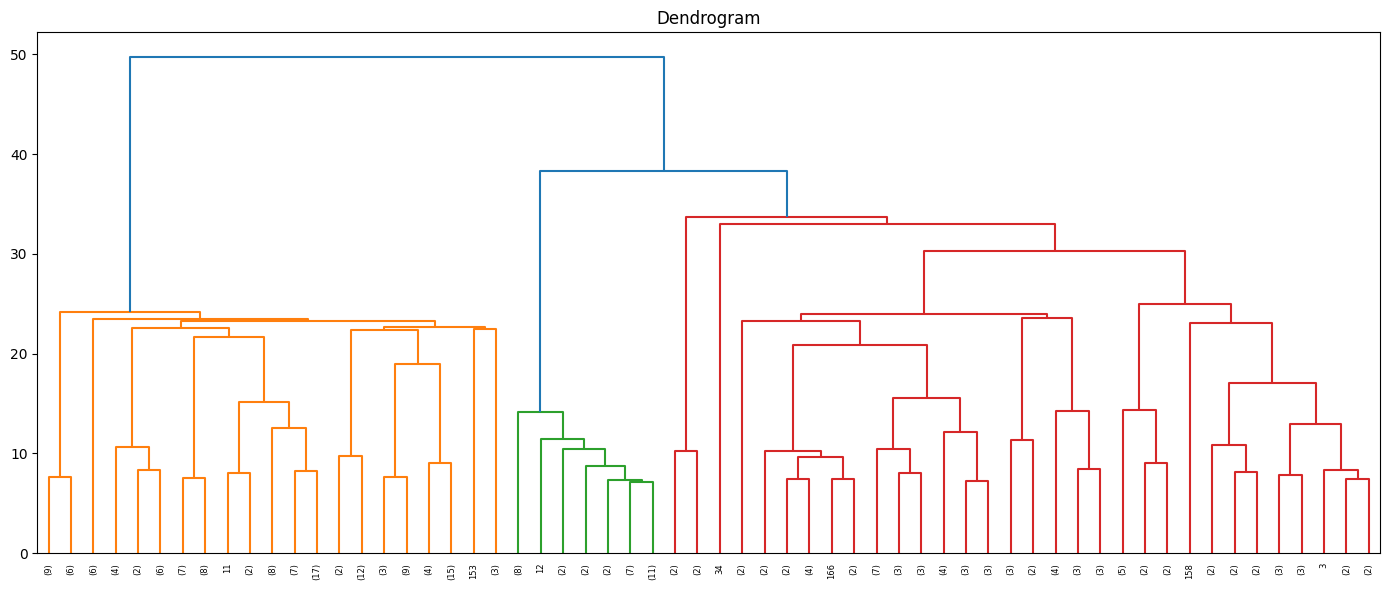

Cluster counts:
Cluster_Label
1    132
3     83
2     33
Name: count, dtype: int64


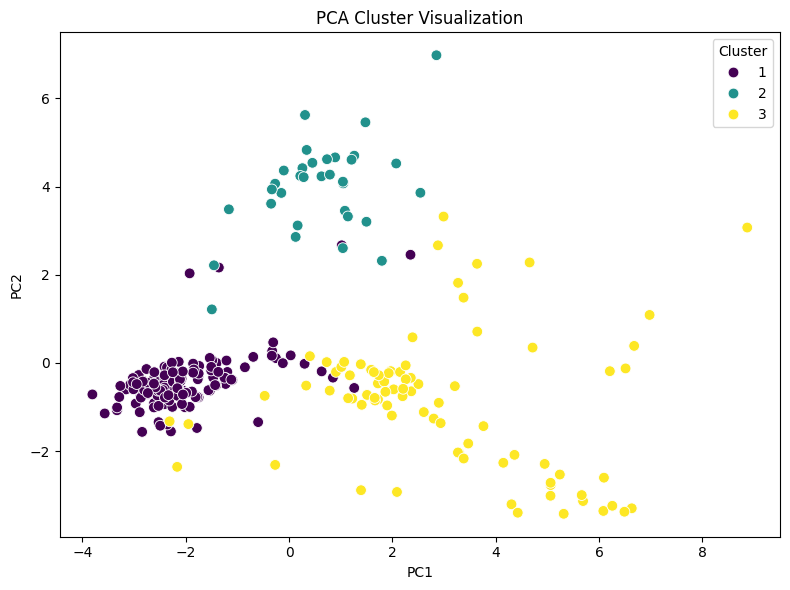

In [11]:
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

# loading the data
data_file = Path("/Users/kamyasarda/Downloads/HPP_IMB529-XLS-ENG.xlsx")

if "MH-Modified Data" in xls.sheet_names:
    df = pd.read_excel(xls, "MH-Modified Data")
else:
    df = pd.read_excel(xls, "MH-Raw Data")

print(df.head())
print(df.columns)

# selecting the target variable
possible = [c for c in df.columns if isinstance(c, str) and any(w in c.lower() for w in ["price","package","amount","cost"])]
target_col = None

for c in possible:
    if pd.api.types.is_numeric_dtype(df[c]):
        target_col = c
        break

if target_col is None:
    num_cols = df.select_dtypes(include=[np.number]).columns
    target_col = num_cols[0]

print("Target selected:", target_col)

# cleaning the data
df = df.dropna(axis=1, how="all")
X = df.drop(columns=[target_col], errors="ignore")
y = df[target_col]

drop_cols = [c for c in X.columns if "id" in c.lower() or "code" in c.lower() or c.lower().startswith("unnamed")]
X = X.drop(columns=drop_cols, errors="ignore")

mask = ~y.isna()
X = X.loc[mask]
y = y.loc[mask]

# encoding categorical variables
X = pd.get_dummies(X, drop_first=True)

# scaling the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# training the prediction model
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# evaluation (avoid using 'squared' kwarg to maintain compatibility)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("RMSE:", rmse)
print("R2:", r2)

# predicting for entire dataset
full_pred = rf.predict(X_scaled)

# storing prediction results
results = df.copy()
results["Predicted_Price"] = full_pred

# hierarchical clustering
linked = linkage(X_scaled, method="ward")

plt.figure(figsize=(14, 6))
dendrogram(linked, truncate_mode="lastp", p=60)
plt.title("Dendrogram")
plt.tight_layout()
plt.show()

# creating 3 clusters
clusters = fcluster(linked, 3, criterion="maxclust")
results["Cluster_Label"] = clusters

print("Cluster counts:")
print(results["Cluster_Label"].value_counts())

# PCA visualization
pca = PCA(n_components=2)
pca_vals = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(pca_vals, columns=["PC1", "PC2"])
pca_df["Cluster"] = clusters

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Cluster", palette="viridis", s=60)
plt.title("PCA Cluster Visualization")
plt.tight_layout()
plt.show()

